In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from model import *

In [5]:
def simStats(vaultTVL, vaultLog) : 
    apy = (vaultLog[-1] / vaultTVL)**(stepsPerYear / nSteps) - 1
    dradown = 0
    prevMax = vaultTVL
    for i in range(len(vaultLog)) : 
        prevMax = max(prevMax, vaultLog[i])
        drawdownT = 1 - vaultLog[i] / prevMax
        drawdown = max(dradown, drawdownT)
    return apy, drawdown



In [93]:
#paramaters for simulation

vaultToken = 'USDC'
secondaryToken = 'FTM'
volume1 =  2000000 #amount of vaultToken in LP
volume2 =  volume1*5 #amount of secondary token in LP

# VAULT INFO
vaultTVL = 2000 # amount of vault Token in LP 
lendAllocation = .5
#debt thresholds for rebalancing
debtLow = .97
debtHigh = 1.03
collatLow = .5
collatTarget = .55
collatHigh = .6
harvestTreshold = 1
rebalanceAdj = .996 #when rebalancing losses from swapping 
#harvestFee = 0.05 # 

# APY's
lendRate = .05
borrowRate = .03
farmRate = .35

#SIM INFO
stepsPerYear = 365*24*60 #if simulating hourly set to be 365 * 24 

annualRates = {'lend' : lendRate, 'borrow' : borrowRate, 'farm' : farmRate}
adjRates = {'lend' : ((1 + lendRate)**(1/stepsPerYear) - 1), 
            'borrow' : ((1 + borrowRate)**(1/stepsPerYear) - 1),
            'farm' : ((1 + farmRate)**(1/stepsPerYear) - 1)}

nSteps = int(stepsPerYear / 365)


In [94]:
# Sim 1 Day 
vol1 = volume1
vol2 = volume2 
lp = createLp(vaultToken, secondaryToken, vol1, vol2)
vaultInitial = createVault(vaultTVL, lendAllocation, vaultToken, secondaryToken, vol1, vol2)
       
pBuy = .6
lambdaTrades = 5 # input for poisson distribution to determine number of trades that occur in given time step
expScale = 100 # input for exponential distribution to determine size of trade 

allTrades = []
      
for i in range(nSteps) : 
    tradeStep = genTradesRandom(lambdaTrades, expScale, pBuy)
    allTrades.append(tradeStep)
    
vaultLog, priceLog, debtRatioLog, collatRatioLog = simulate(allTrades, vaultInitial, lp, vaultToken, 
                                                            secondaryToken, vol1, vol2, adjRates)
# Sim 1 Day No Rebalance
vol1 = volume1
vol2 = volume2 
lp = createLp(vaultToken, secondaryToken, vol1, vol2)
vaultInitial = createVault(vaultTVL, lendAllocation, vaultToken, secondaryToken, vol1, vol2)
       
vaultLog1, priceLog1, debtRatioLog1, collatRatioLog1 = simulate(allTrades, vaultInitial, lp, vaultToken, 
                                                            secondaryToken, vol1, vol2, adjRates, rebalance = False)

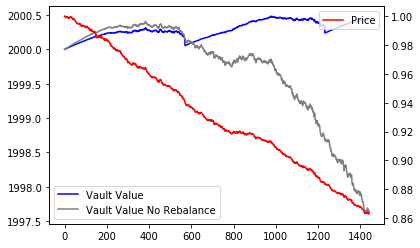

In [99]:
fig, ax = plt.subplots()

ax.plot(vaultLog, color = 'blue', label = 'Vault Value' )
ax.plot(vaultLog1, color = 'grey', label = 'Vault Value No Rebalance' )

ax.legend()

ax2 = ax.twinx()
ax2.plot(priceLog, color = 'red', label = 'Price')
#ax2.plot(debtRatioLog, color = 'orange', label = 'Debt Ratio')
ax2.legend()
plt.show()

Above graph shows how Vault with Rebalancing performs vs Vault with no rebalancing when price drops significantly 

In [102]:
# impact of volatility on returns 
nSims = 200
apyLog = []
stdDevLog = []
priceRangeLog = []
drawdownLog = []
for j in range(nSims) :     
    vol1 = volume1
    vol2 = volume2 
    lp = createLp(vaultToken, secondaryToken, vol1, vol2)
    vaultInitial = createVault(vaultTVL, lendAllocation, vaultToken, secondaryToken, vol1, vol2)
    lambdaTrades = 5 # input for poisson distribution
    allTrades = []
    for i in range(nSteps) : 
        tradeStep = genTradesRandom(lambdaTrades, expScale, pBuy)
        allTrades.append(tradeStep)

    vaultLog, priceLog, debtRatioLog, collatRatioLog = simulate(allTrades, vaultInitial, lp, vaultToken, 
                                                                secondaryToken, vol1, vol2, adjRates)
    
    apy, drawdown = simStats(vaultTVL, vaultLog)
    apyLog.append(apy)
    drawdownLog.append(drawdown)

    stdDevLog.append(numpy.std(priceLog))
    priceRangeLog.append(max(priceLog) / min(priceLog) - 1)
    



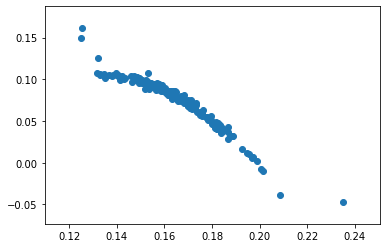

In [103]:
plt.scatter(priceRangeLog, apyLog)

Above shows APY vs the % difference in the max price and the min price over the simulated period. 

In [104]:
#extereme price movements example 

pLow = .2; pHigh = 1 - pLow
nSims = 100
pBuy = pLow
pIncr = (pHigh - pLow) / nSims

apyLog = []
stdDevLog = []
priceRangeLog = []
priceChangeLog = []
drawdownLog = []

for j in range(nSims) :     
    vol1 = volume1
    vol2 = volume2 
    lp = createLp(vaultToken, secondaryToken, vol1, vol2)
    vaultInitial = createVault(vaultTVL, lendAllocation, vaultToken, secondaryToken, vol1, vol2)
    lambdaTrades = 5 # input for poisson distribution
    allTrades = []
    for i in range(nSteps) : 
        tradeStep = genTradesRandom(lambdaTrades, expScale, pBuy)
        allTrades.append(tradeStep)

    vaultLog, priceLog, debtRatioLog, collatRatioLog = simulate(allTrades, vaultInitial, lp, vaultToken, 
                                                                secondaryToken, vol1, vol2, adjRates)
    
    apy, drawdown = simStats(vaultTVL, vaultLog)
    apyLog.append(apy)
    drawdownLog.append(drawdown)

    stdDevLog.append(numpy.std(priceLog))
    priceRangeLog.append(max(priceLog) / min(priceLog) - 1)
    priceChangeLog.append(priceLog[-1] / priceLog[0] - 1)
    pBuy += pIncr
    


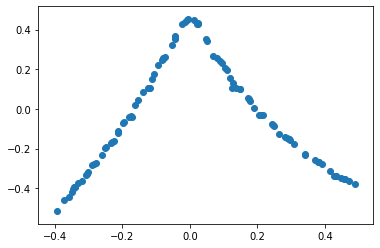

In [106]:
plt.scatter(priceChangeLog, apyLog)

In [33]:
# APY range for debt thresholds vs volatility 

pBuy = 0.5

nSims = 50 # number of different randomly simulated price changes over period 
expScale = 500

dStart = .01; dEnd = .1
dIncr = (dEnd - dStart) / 100

apyLogs = []
debtRangeLogs = []

   
allTrades = []
for i in range(nSteps) : 
    tradeStep = genTradesRandom(lambdaTrades, expScale, pBuy)
    allTrades.append(tradeStep)

dRange = dStart
dLow = 1 - dRange / 2
dHigh = 1 + dRange / 2

for j in range(nSims) :
    vol1 = volume1
    vol2 = volume2 
    lp = createLp(vaultToken, secondaryToken, vol1, vol2)
    vaultInitial = createVault(vaultTVL, lendAllocation, vaultToken, secondaryToken, vol1, vol2)
    vaultLog, priceLog, debtRatioLog, collatRatioLog = simulate(allTrades, vaultInitial, lp, vaultToken, 
                                                                secondaryToken, vol1, vol2, adjRates,
                                                               debtLow = dLow, debtHigh = dHigh)

    apy, drawdown = simStats(vaultTVL, vaultLog)

    apyLogs.append(apy)
    debtRangeLogs.append(dRange)
    

    dRange += dIncr
    dLow = 1 - dRange / 2
    dHigh = 1 + dRange / 2

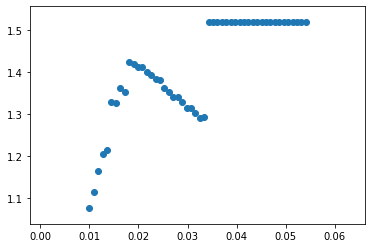

In [34]:
plt.scatter(debtRangeLogs, apyLogs)

In [ ]:
# APY range for debt thresholds vs volatility 

pBuy = 0.5

nSims = 10 # number of different randomly simulated price changes over period 
expScale = 100
expScaleIncr = 50

nDebtRanges = 10
dStart = .01; dEnd = .2
dIncr = (dEnd - dStart) / nDebtRanges

apyLogs = numpy.zeros((nSims, nDebtRanges))

for j in range(nSims) :   
    # generate trade scenarios for price movements
    allTrades = []
    for i in range(nSteps) : 
        tradeStep = genTradesRandom(lambdaTrades, expScale, pBuy)
        allTrades.append(tradeStep)
    
    dRange = dStart
    dLow = 1 - dRange / 2
    dHigh = 1 + dRange / 2
    
    for k in range(nDebtRanges) :
        vol1 = volume1
        vol2 = volume2 
        lp = createLp(vaultToken, secondaryToken, vol1, vol2)
        vaultInitial = createVault(vaultTVL, lendAllocation, vaultToken, secondaryToken, vol1, vol2)
        vaultLog, priceLog, debtRatioLog, collatRatioLog = simulate(allTrades, vaultInitial, lp, vaultToken, 
                                                                    secondaryToken, vol1, vol2, adjRates,
                                                                   debtLow = dLow, debtHigh = dHigh)

        apy, drawdown = simStats(vaultTVL, vaultLog)
        
        apyLogs[j,k] = apy
        
        dRange += dIncr
        dLow = 1 - dRange / 2
        dHigh = 1 + dRange / 2

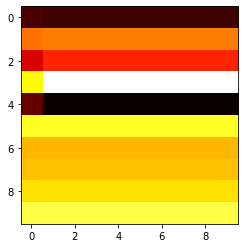

In [16]:
plt.imshow(apyLogs, cmap='hot', interpolation='nearest')
plt.show()

In [20]:
apyLogs

array([[0.43000132, 0.42946209, 0.42946209, 0.42946209, 0.42946209,
        0.42946209, 0.42946209, 0.42946209, 0.42946209, 0.42946209],
       [0.44357359, 0.44403804, 0.44403804, 0.44403804, 0.44403804,
        0.44403804, 0.44403804, 0.44403804, 0.44403804, 0.44403804],
       [0.43663491, 0.43993532, 0.43993532, 0.43993532, 0.43993532,
        0.43993532, 0.43993532, 0.43993532, 0.43993532, 0.43993532],
       [0.44974213, 0.45771602, 0.45771602, 0.45771602, 0.45771602,
        0.45771602, 0.45771602, 0.45771602, 0.45771602, 0.45771602],
       [0.43117919, 0.4270665 , 0.4270665 , 0.4270665 , 0.4270665 ,
        0.4270665 , 0.4270665 , 0.4270665 , 0.4270665 , 0.4270665 ],
       [0.45102887, 0.45102887, 0.45102887, 0.45102887, 0.45102887,
        0.45102887, 0.45102887, 0.45102887, 0.45102887, 0.45102887],
       [0.44670128, 0.44670128, 0.44670128, 0.44670128, 0.44670128,
        0.44670128, 0.44670128, 0.44670128, 0.44670128, 0.44670128],
       [0.44714242, 0.44714242, 0.4471424